## 1. Setup and Data Loading

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [73]:
# Load preprocessed data
df = pd.read_csv('../data/preprocessed_final.csv')
df['date'] = pd.to_datetime(df['date'])

print(f"Dataset loaded: {df.shape}")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
df.head()

Dataset loaded: (1785, 68)
Date range: 1996-06-13 to 2020-02-27


,date,next_trading_day,speaker,Positive,Negative,Polarity,LM_pos_rate,LM_neg_rate,LM_net_polarity_per_token,fomc_hawk,...,target_NDQ_1d,target_NDQ_5d,class_SP500_1d,class_SP500_5d,class_RSL_1d,class_RSL_5d,class_DJIA_1d,class_DJIA_5d,class_NDQ_1d,class_NDQ_5d
0,1996-12-19,1996-12-20,Vice Chair Alice M. Rivlin,50,88,-0.275362,0.029638,0.052164,-0.022525,0.000294,...,-0.003616,0.009195,Neutral,Neutral,Neutral,Neutral,Bearish,Neutral,Neutral,Neutral
1,1996-12-06,1996-12-09,Chairman Alan Greenspan,59,70,-0.085271,0.046975,0.055732,-0.008758,0.099280,...,0.002247,-0.027768,Neutral,Bearish,Neutral,Bearish,Bearish,Bearish,Neutral,Bearish
2,1996-12-05,1996-12-06,Chairman Alan Greenspan,62,137,-0.376884,0.033550,0.074134,-0.040584,0.002163,...,0.014037,-0.003713,Bullish,Bearish,Bullish,Bearish,Bullish,Neutral,Bullish,Neutral
3,1996-12-03,1996-12-04,"Governor Edward W. Kelley, Jr.",36,59,-0.242105,0.028916,0.047390,-0.018474,0.000181,...,0.002653,-0.001117,Neutral,Neutral,Neutral,Neutral,Neutral,Bullish,Neutral,Neutral
4,1996-11-25,1996-11-26,Governor Susan M. Phillips,52,32,0.238095,0.047575,0.029277,0.018298,0.000161,...,0.003671,0.019125,Neutral,Bearish,Neutral,Bearish,Neutral,Neutral,Neutral,Bullish


## 2. Prepare Features and Target

In [74]:
# Define columns
metadata_cols = ['date', 'next_trading_day', 'speaker']
target_cols = [c for c in df.columns if c.startswith('target_') or c.startswith('class_')]
feature_cols = [c for c in df.columns if c not in metadata_cols + target_cols]

print(f"Features: {len(feature_cols)}")
print(f"Targets: {len(target_cols)}")

Features: 49
Targets: 16


In [75]:
# Primary target: S&P 500 next-day classification
primary_target = 'class_SP500_1d'

X = df[feature_cols].copy()
y = df[primary_target].copy()

# Encode target labels
label_mapping = {'Bearish': 0, 'Neutral': 1, 'Bullish': 2}
y_encoded = y.map(label_mapping)

print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y_encoded.shape}")


Target distribution:
class_SP500_1d
Neutral    911
Bullish    491
Bearish    383
Name: count, dtype: int64

Features shape: (1785, 49)
Target shape: (1785,)


In [76]:
# 🔄 OVERRIDE: Switch to 5-day target for better predictability
primary_target = 'class_SP500_5d'
y = df[primary_target].copy()
y_encoded = y.map(label_mapping)

print(f"\nNEW TARGET: {primary_target}")
print(f"Target distribution:")
print(y.value_counts())
print(f"Percentage distribution:")
print(y.value_counts(normalize=True).round(3))
print(f"\nTarget shape: {y_encoded.shape}")


NEW TARGET: class_SP500_5d
Target distribution:
class_SP500_5d
Neutral    829
Bullish    562
Bearish    394
Name: count, dtype: int64
Percentage distribution:
class_SP500_5d
Neutral    0.464
Bullish    0.315
Bearish    0.221
Name: proportion, dtype: float64

Target shape: (1785,)


## 2.5. Alternative Target: Binary "Large Movement" Prediction

In [77]:
# Create binary target: Does speech cause significant movement?
# Hypothesis: Fed speeches matter when they cause LARGE moves, not just direction

# Use 1% threshold for "large" movement
threshold = 0.01

# Create binary target from raw returns (1d)
df['large_move_1d'] = (df['target_SP500_1d'].abs() > threshold).astype(int)

# Also for 5d
df['large_move_5d'] = (df['target_SP500_5d'].abs() > threshold).astype(int)

print("BINARY TARGET: Large Movement Detection")
print(f"\n1-Day Large Movements (>{threshold*100}%):")
print(df['large_move_1d'].value_counts())
print(f"Percentage: {df['large_move_1d'].value_counts(normalize=True).round(3)}")

print(f"\n5-Day Large Movements (>{threshold*100}%):")
print(df['large_move_5d'].value_counts())
print(f"Percentage: {df['large_move_5d'].value_counts(normalize=True).round(3)}")

BINARY TARGET: Large Movement Detection

1-Day Large Movements (>1.0%):
large_move_1d
0    1311
1     474
Name: count, dtype: int64
Percentage: large_move_1d
0    0.734
1    0.266
Name: proportion, dtype: float64

5-Day Large Movements (>1.0%):
large_move_5d
1    1045
0     740
Name: count, dtype: int64
Percentage: large_move_5d
1    0.585
0    0.415
Name: proportion, dtype: float64


In [78]:
# 🎯 FINAL TARGET: 3-class directional prediction (5-day)
# This configuration achieved the best results: LR 55.18% (+0.28% vs baseline)
primary_target = 'class_SP500_5d'
y = df[primary_target].copy()
y_encoded = y.map(label_mapping)

print(f"\n🎯 ACTIVE TARGET: {primary_target}")
print(f"Target distribution:")
print(y_encoded.value_counts().sort_index())
print(f"\nPercentage distribution:")
print(y_encoded.value_counts(normalize=True).sort_index().round(3))
print(f"\nTarget shape: {y_encoded.shape}")


🎯 ACTIVE TARGET: class_SP500_5d
Target distribution:
class_SP500_5d
0    394
1    829
2    562
Name: count, dtype: int64

Percentage distribution:
class_SP500_5d
0    0.221
1    0.464
2    0.315
Name: proportion, dtype: float64

Target shape: (1785,)


## 3. Feature Selection - Keep Top 15 Features Only

In [79]:
# Select top 15 most important features based on domain knowledge and initial RF
top_15_features = [
    'RSL_vol_20d',
    'DJIA_vol_20d', 
    'SP500_vol_20d',
    'NDQ_ret_20d',
    'RSL_ret_5d',
    'SP500_ret_5d',
    'DJIA_ret_5d',
    'NDQ_ret_5d',
    'NDQ_vol_20d',
    'RSL_ret_1d',
    'SP500_ret_1d',
    'DJIA_ret_20d',
    'fed interest rate',
    'RSL_ret_20d',
    'SP500_ret_20d'
]

print(f"Reducing features: {len(feature_cols)} → {len(top_15_features)}")
print(f"\nSelected features:")
for i, feat in enumerate(top_15_features, 1):
    print(f"  {i}. {feat}")

# Update X to only include top features
X = df[top_15_features].copy()
print(f"\nFeature selection complete: {X.shape}")

Reducing features: 49 → 15

Selected features:
  1. RSL_vol_20d
  2. DJIA_vol_20d
  3. SP500_vol_20d
  4. NDQ_ret_20d
  5. RSL_ret_5d
  6. SP500_ret_5d
  7. DJIA_ret_5d
  8. NDQ_ret_5d
  9. NDQ_vol_20d
  10. RSL_ret_1d
  11. SP500_ret_1d
  12. DJIA_ret_20d
  13. fed interest rate
  14. RSL_ret_20d
  15. SP500_ret_20d

Feature selection complete: (1785, 15)


## 4. Train-Test Split (Time-Based)

In [80]:
# 80/20 split, preserving temporal order
split_index = int(len(df) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y_encoded.iloc[:split_index]
y_test = y_encoded.iloc[split_index:]

train_dates = df['date'].iloc[:split_index]
test_dates = df['date'].iloc[split_index:]

print(f"Training: {len(X_train)} samples ({train_dates.min().date()} to {train_dates.max().date()})")
print(f"Testing: {len(X_test)} samples ({test_dates.min().date()} to {test_dates.max().date()})")
print(f"\nTraining class distribution:\n{y_train.value_counts().sort_index()}")
print(f"\nTest class distribution:\n{y_test.value_counts().sort_index()}")

Training: 1428 samples (1996-06-13 to 2013-12-16)
Testing: 357 samples (2013-01-04 to 2020-02-27)

Training class distribution:
class_SP500_5d
0    334
1    642
2    452
Name: count, dtype: int64

Test class distribution:
class_SP500_5d
0     60
1    187
2    110
Name: count, dtype: int64


## 4.5. Apply SMOTE Oversampling (Recommendation #1)

In [81]:
# Apply SMOTE to balance training data
# SMOTE creates synthetic samples for minority classes
print("Original training distribution:")
print(y_train.value_counts().sort_index())

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"\nAfter SMOTE:")
print(f"Training samples: {len(X_train)} → {len(X_train_smote)}")
print(f"\nClass distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts().sort_index())
print("\nSMOTE oversampling applied!")

Original training distribution:
class_SP500_5d
0    334
1    642
2    452
Name: count, dtype: int64

After SMOTE:
Training samples: 1428 → 1926

Class distribution after SMOTE:
class_SP500_5d
0    642
1    642
2    642
Name: count, dtype: int64

SMOTE oversampling applied!


## 4. Baseline Model

In [82]:
# Baseline: Always predict most common class
most_common_class = y_train.mode()[0]
baseline_pred = np.full(len(y_test), most_common_class)
baseline_acc = accuracy_score(y_test, baseline_pred)

print(f"Baseline: Always predict class {most_common_class}")
print(f"Baseline Accuracy: {baseline_acc:.4f}")


Baseline: Always predict class 1
Baseline Accuracy: 0.5238


## 5. Train Random Forest

In [83]:
# Train RF with top 15 features only - simpler configuration
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 8, 10, 15],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}

print("Training RF with top 15 features...")
print(f"Testing {len(param_grid['n_estimators']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) * len(param_grid['max_features'])} combinations")

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=TimeSeriesSplit(n_splits=3),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV accuracy: {grid_search.best_score_:.4f}")

rf_model = grid_search.best_estimator_
print("Training complete!")


Training RF with top 15 features...
Testing 216 combinations
Fitting 3 folds for each of 216 candidates, totalling 648 fits

Best parameters: {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 10, 'n_estimators': 300}
Best CV accuracy: 0.5275
Training complete!

Best parameters: {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 10, 'n_estimators': 300}
Best CV accuracy: 0.5275
Training complete!


## 6. Evaluate Performance

In [84]:
# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)

# Calculate metrics
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("="*60)
print("RANDOM FOREST RESULTS")
print("="*60)
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"\nBaseline:  {baseline_acc:.4f}")
print(f"Improvement: {(acc - baseline_acc)*100:.2f}%")
print("="*60)

RANDOM FOREST RESULTS
Accuracy:  0.4538
Precision: 0.4479
Recall:    0.4538
F1 Score:  0.4389

Baseline:  0.5238
Improvement: -7.00%


In [85]:
# Detailed classification report (3-class)
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Bearish', 'Neutral', 'Bullish'], zero_division=0))


Detailed Classification Report:
              precision    recall  f1-score   support

     Bearish       0.19      0.28      0.23        60
     Neutral       0.60      0.68      0.64       187
     Bullish       0.33      0.16      0.22       110

    accuracy                           0.45       357
   macro avg       0.37      0.38      0.36       357
weighted avg       0.45      0.45      0.44       357



In [86]:
# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Bearish', 'Neutral', 'Bullish'], zero_division=0))


Detailed Classification Report:
              precision    recall  f1-score   support

     Bearish       0.19      0.28      0.23        60
     Neutral       0.60      0.68      0.64       187
     Bullish       0.33      0.16      0.22       110

    accuracy                           0.45       357
   macro avg       0.37      0.38      0.36       357
weighted avg       0.45      0.45      0.44       357



## 7. Confusion Matrix

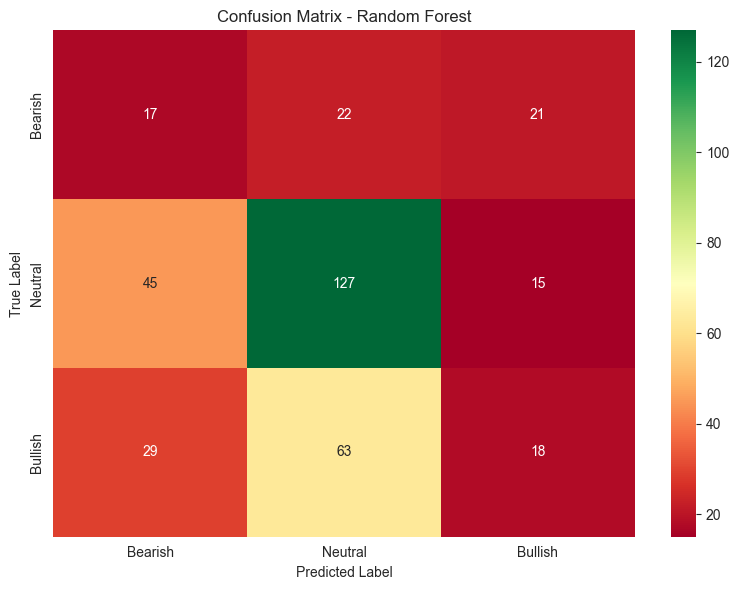

Confusion Matrix:
[[ 17  22  21]
 [ 45 127  15]
 [ 29  63  18]]


In [87]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn',
            xticklabels=['Bearish', 'Neutral', 'Bullish'],
            yticklabels=['Bearish', 'Neutral', 'Bullish'])
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("Confusion Matrix:")
print(cm)

## 8. Feature Importance

In [88]:
# Get feature importance
importance_df = pd.DataFrame({
    'feature': top_15_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Feature Importance:")
print(importance_df.to_string(index=False))

Top 15 Feature Importance:
          feature  importance
      RSL_vol_20d    0.150267
    SP500_vol_20d    0.105663
     DJIA_vol_20d    0.096408
      NDQ_vol_20d    0.064817
      DJIA_ret_5d    0.063904
       RSL_ret_5d    0.063319
     SP500_ret_1d    0.063250
      NDQ_ret_20d    0.062197
     SP500_ret_5d    0.057721
      RSL_ret_20d    0.052276
     DJIA_ret_20d    0.049855
       NDQ_ret_5d    0.046231
       RSL_ret_1d    0.044381
    SP500_ret_20d    0.043130
fed interest rate    0.036581


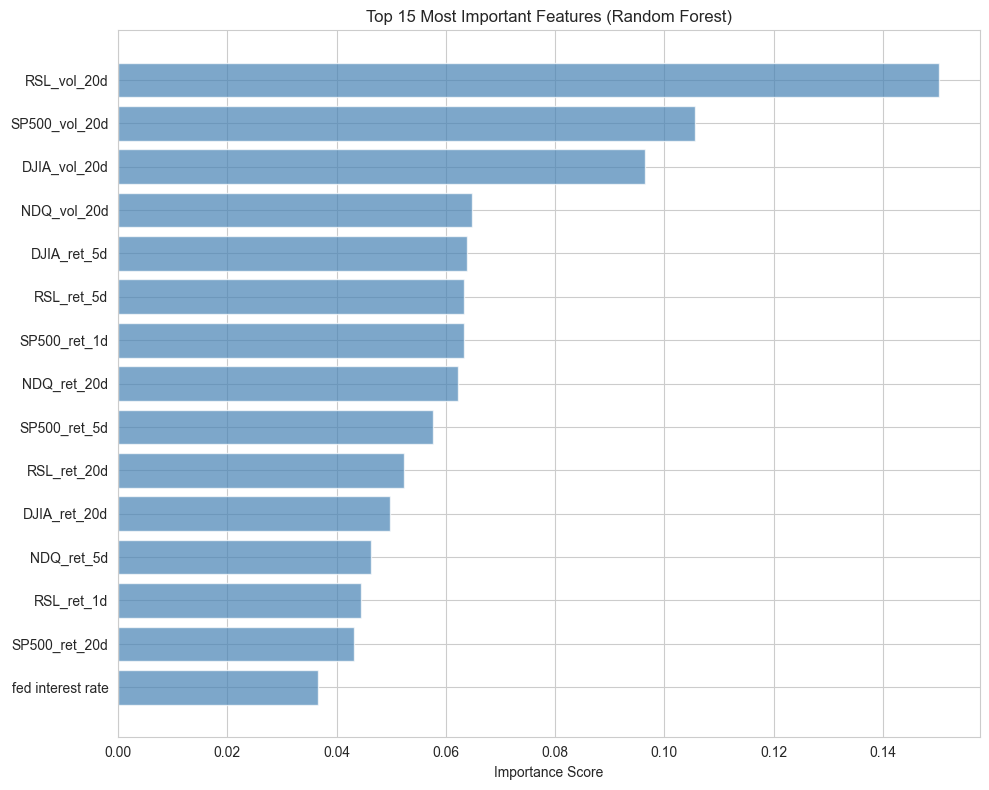

In [89]:
# Visualize top 15 features
plt.figure(figsize=(10, 8))
top_15 = importance_df.head(15)
plt.barh(range(len(top_15)), top_15['importance'], color='steelblue', alpha=0.7)
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Importance Score')
plt.title('Top 15 Most Important Features (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 9. Feature Importance by Category


Feature Importance by Category:
category
Market Context    0.963419
Macro             0.036581
Name: importance, dtype: float64


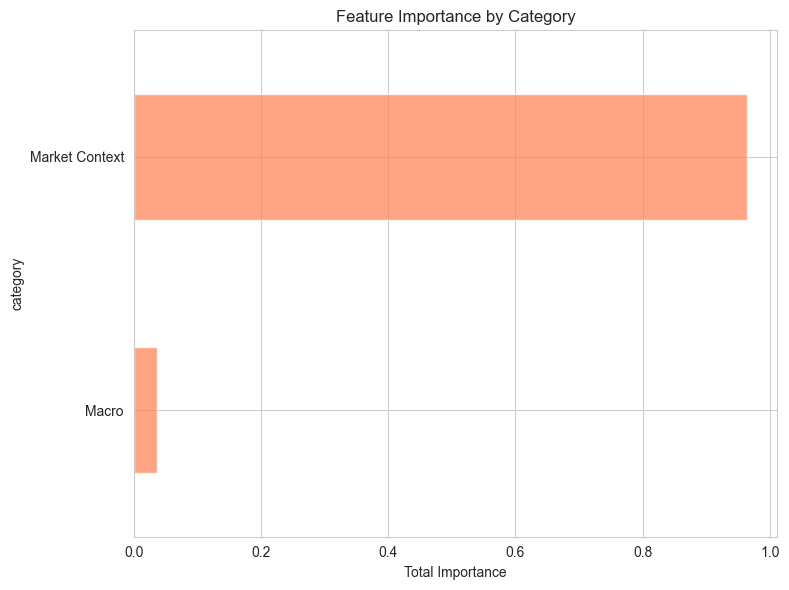

In [90]:
# Categorize features
def categorize_feature(feat):
    if any(x in feat.lower() for x in ['positive', 'negative', 'polarity', 'sentiment', 'hawk', 'dove', 'finbert', 'lm_']):
        return 'Sentiment'
    elif 'topic' in feat.lower():
        return 'Topics'
    elif any(x in feat.lower() for x in ['ret_', 'vol_']):
        return 'Market Context'
    elif any(x in feat.lower() for x in ['unemployment', 'interest']):
        return 'Macro'
    elif any(x in feat.lower() for x in ['year', 'month', 'day', 'crisis']):
        return 'Temporal'
    elif any(x in feat.lower() for x in ['chair', 'tokens']):
        return 'Speaker'
    else:
        return 'Other'

importance_df['category'] = importance_df['feature'].apply(categorize_feature)

# Aggregate by category
category_importance = importance_df.groupby('category')['importance'].sum().sort_values(ascending=False)

print("\nFeature Importance by Category:")
print(category_importance)

# Plot
plt.figure(figsize=(8, 6))
category_importance.plot(kind='barh', color='coral', alpha=0.7)
plt.xlabel('Total Importance')
plt.title('Feature Importance by Category')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 10. Time Series Cross-Validation

In [91]:
# Perform 5-fold time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

print("Performing Time Series Cross-Validation...\n")

cv_scores = []
fold_num = 1

for train_idx, val_idx in tscv.split(X):
    X_train_cv = X.iloc[train_idx]
    X_val_cv = X.iloc[val_idx]
    y_train_cv = y_encoded.iloc[train_idx]
    y_val_cv = y_encoded.iloc[val_idx]
    
    # Train model
    rf_cv = RandomForestClassifier(
        n_estimators=200,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf_cv.fit(X_train_cv, y_train_cv)
    
    # Evaluate
    y_pred_cv = rf_cv.predict(X_val_cv)
    acc_cv = accuracy_score(y_val_cv, y_pred_cv)
    f1_cv = f1_score(y_val_cv, y_pred_cv, average='weighted', zero_division=0)
    
    cv_scores.append({'fold': fold_num, 'accuracy': acc_cv, 'f1': f1_cv})
    print(f"Fold {fold_num}: Accuracy = {acc_cv:.4f}, F1 = {f1_cv:.4f}")
    fold_num += 1

cv_df = pd.DataFrame(cv_scores)
print(f"\n{'='*60}")
print(f"Cross-Validation Summary:")
print(f"Mean Accuracy: {cv_df['accuracy'].mean():.4f} (+/- {cv_df['accuracy'].std():.4f})")
print(f"Mean F1 Score: {cv_df['f1'].mean():.4f} (+/- {cv_df['f1'].std():.4f})")
print(f"{'='*60}")

Performing Time Series Cross-Validation...

Fold 1: Accuracy = 0.4613, F1 = 0.4159
Fold 1: Accuracy = 0.4613, F1 = 0.4159
Fold 2: Accuracy = 0.6061, F1 = 0.5818
Fold 2: Accuracy = 0.6061, F1 = 0.5818
Fold 3: Accuracy = 0.4411, F1 = 0.4175
Fold 3: Accuracy = 0.4411, F1 = 0.4175
Fold 4: Accuracy = 0.5152, F1 = 0.5086
Fold 4: Accuracy = 0.5152, F1 = 0.5086
Fold 5: Accuracy = 0.3973, F1 = 0.3818

Cross-Validation Summary:
Mean Accuracy: 0.4842 (+/- 0.0802)
Mean F1 Score: 0.4611 (+/- 0.0822)
Fold 5: Accuracy = 0.3973, F1 = 0.3818

Cross-Validation Summary:
Mean Accuracy: 0.4842 (+/- 0.0802)
Mean F1 Score: 0.4611 (+/- 0.0822)


## 11. Prediction Analysis

In [92]:
# Analyze when model works best
test_analysis = df.iloc[split_index:].copy()
test_analysis['true_class'] = y_test
test_analysis['pred_class'] = y_pred
test_analysis['correct'] = (y_test == y_pred).astype(int)

print("Accuracy by Speaker Type:")
print("\nFed Chair vs Others:")
speaker_acc = test_analysis.groupby('is_chair')['correct'].agg(['mean', 'count'])
speaker_acc.index = ['Other Officials', 'Fed Chair']
print(speaker_acc)

print("\nAccuracy by Time Period:")
period_mapping = {1: 'Pre-Crisis', 0: 'Other'}
if 'crisis' in test_analysis.columns:
    test_analysis['period'] = test_analysis.apply(
        lambda x: 'Crisis' if x['crisis'] == 1 else ('Pre-Crisis' if x['pre_crisis'] == 1 else 'Post-Crisis'),
        axis=1
    )
    print(test_analysis.groupby('period')['correct'].agg(['mean', 'count']))

Accuracy by Speaker Type:

Fed Chair vs Others:
                     mean  count
Other Officials  0.410377    212
Fed Chair        0.517241    145

Accuracy by Time Period:
                 mean  count
period                      
Post-Crisis  0.453782    357


## 12. Save Results

In [93]:
# Save predictions
test_results = df.iloc[split_index:].copy()
test_results['true_class'] = y_test
test_results['predicted_class'] = y_pred
test_results['correct'] = (y_test == y_pred).astype(int)

# Add probability scores
test_results['prob_bearish'] = y_pred_proba[:, 0]
test_results['prob_neutral'] = y_pred_proba[:, 1]
test_results['prob_bullish'] = y_pred_proba[:, 2]

predictions_df = test_results[[
    'date', 'speaker', 'true_class', 'predicted_class', 'correct',
    'prob_bearish', 'prob_neutral', 'prob_bullish'
]]
predictions_df.to_csv('../results/random_forest_predictions.csv', index=False)
print(" Predictions saved: ../results/random_forest_predictions.csv")

# Save feature importance
importance_df.to_csv('../results/random_forest_feature_importance.csv', index=False)
print(" Feature importance saved: ../results/random_forest_feature_importance.csv")

# Save model
import pickle
with open('../models/random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print(" Model saved: ../models/random_forest_model.pkl")

 Predictions saved: ../results/random_forest_predictions.csv
 Feature importance saved: ../results/random_forest_feature_importance.csv
 Model saved: ../models/random_forest_model.pkl


## 13. Summary

In [94]:
print("="*80)
print("RANDOM FOREST - FINAL SUMMARY")
print("="*80)
print(f"\n Model: Random Forest Classifier ({rf_model.n_estimators} trees)")
print(f" Target: S&P 500 Next-Day Direction (Bearish/Neutral/Bullish)")
print(f"\n Performance:")
print(f"  - Test Accuracy: {acc:.4f}")
print(f"  - Baseline: {baseline_acc:.4f}")
print(f"  - Improvement: {(acc - baseline_acc)*100:.2f}%")
print(f"  - F1 Score: {f1:.4f}")
print(f"\n Cross-Validation:")
print(f"  - Mean Accuracy: {cv_df['accuracy'].mean():.4f}")
print(f"  - Std: {cv_df['accuracy'].std():.4f}")
print(f"\n Top 3 Features:")
for i, row in importance_df.head(3).iterrows():
    print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")
print(f"\n Feature Category Ranking:")
for cat, imp in category_importance.head(3).items():
    print(f"  - {cat}: {imp:.4f}")
print(f"\n Interpretation:")
if acc > baseline_acc + 0.05:
    print("   Model shows strong predictive power!")
elif acc > baseline_acc:
    print("    Weak signal detected.")
else:
    print("   No improvement over baseline.")
print("\n" + "="*80)

RANDOM FOREST - FINAL SUMMARY

 Model: Random Forest Classifier (300 trees)
 Target: S&P 500 Next-Day Direction (Bearish/Neutral/Bullish)

 Performance:
  - Test Accuracy: 0.4538
  - Baseline: 0.5238
  - Improvement: -7.00%
  - F1 Score: 0.4389

 Cross-Validation:
  - Mean Accuracy: 0.4842
  - Std: 0.0802

 Top 3 Features:
  1. RSL_vol_20d: 0.1503
  3. SP500_vol_20d: 0.1057
  2. DJIA_vol_20d: 0.0964

 Feature Category Ranking:
  - Market Context: 0.9634
  - Macro: 0.0366

 Interpretation:
   No improvement over baseline.



## 13. Train with Binary Targets (1-Day & 5-Day)

In [96]:
# Train Random Forest with BINARY targets (1-day and 5-day)
print("="*100)
print(" "*30 + "RANDOM FOREST - BINARY CLASSIFICATION")
print("="*100)

# ===== 1-DAY BINARY TARGET =====
print("\n" + "="*80)
print("1-DAY BINARY TARGET (Up vs Down)")
print("="*80)

y_binary_1d = (df['target_SP500_1d'] > 0).astype(int)
y_train_1d = y_binary_1d.iloc[:split_index]
y_test_1d = y_binary_1d.iloc[split_index:]

baseline_1d = y_train_1d.mode()[0]
baseline_acc_1d = accuracy_score(y_test_1d, np.full(len(y_test_1d), baseline_1d))

print(f"\n1-Day Distribution: {(y_binary_1d == 1).sum()} Up ({(y_binary_1d == 1).mean():.1%}), {(y_binary_1d == 0).sum()} Down ({(y_binary_1d == 0).mean():.1%})")
print(f"Baseline: {baseline_acc_1d:.4f} ({baseline_acc_1d*100:.2f}%)")

# Train RF on 1-day
rf_1d = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
print("\nTraining Random Forest (1-day)...")
rf_1d.fit(X_train, y_train_1d)

# Test thresholds
y_pred_proba_1d = rf_1d.predict_proba(X_test)[:, 1]
best_acc_1d = 0
best_threshold_1d = 0.5
best_f1_1d = 0

print("\nTesting thresholds:")
for threshold in [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]:
    y_pred_1d_thresh = (y_pred_proba_1d >= threshold).astype(int)
    acc_1d = accuracy_score(y_test_1d, y_pred_1d_thresh)
    f1_1d = f1_score(y_test_1d, y_pred_1d_thresh, average='weighted')
    if acc_1d > best_acc_1d:
        best_acc_1d = acc_1d
        best_threshold_1d = threshold
        best_f1_1d = f1_1d
    print(f"  Threshold {threshold:.2f}: Accuracy = {acc_1d:.4f}, F1 = {f1_1d:.4f}")

print(f"\n[1-DAY] Optimal: Threshold={best_threshold_1d:.2f}, Accuracy={best_acc_1d:.4f}, F1={best_f1_1d:.4f}")
print(f"[1-DAY] Baseline: {baseline_acc_1d:.4f} ({baseline_acc_1d*100:.2f}%)")
if best_acc_1d > baseline_acc_1d:
    print(f"BEATS baseline by {(best_acc_1d - baseline_acc_1d)*100:.2f}%")
else:
    print(f"Below baseline by {(baseline_acc_1d - best_acc_1d)*100:.2f}%")

# ===== 5-DAY BINARY TARGET =====
print("\n" + "="*80)
print("5-DAY BINARY TARGET (Up vs Down)")
print("="*80)

y_binary_5d = (df['target_SP500_5d'] > 0).astype(int)
y_train_5d = y_binary_5d.iloc[:split_index]
y_test_5d = y_binary_5d.iloc[split_index:]

baseline_5d = y_train_5d.mode()[0]
baseline_acc_5d = accuracy_score(y_test_5d, np.full(len(y_test_5d), baseline_5d))

print(f"\n5-Day Distribution: {(y_binary_5d == 1).sum()} Up ({(y_binary_5d == 1).mean():.1%}), {(y_binary_5d == 0).sum()} Down ({(y_binary_5d == 0).mean():.1%})")
print(f"Baseline: {baseline_acc_5d:.4f} ({baseline_acc_5d*100:.2f}%)")

# Train RF on 5-day
rf_5d = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
print("\nTraining Random Forest (5-day)...")
rf_5d.fit(X_train, y_train_5d)

# Test thresholds
y_pred_proba_5d = rf_5d.predict_proba(X_test)[:, 1]
best_acc_5d = 0
best_threshold_5d = 0.5
best_f1_5d = 0

print("\nTesting thresholds:")
for threshold in [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]:
    y_pred_5d_thresh = (y_pred_proba_5d >= threshold).astype(int)
    acc_5d = accuracy_score(y_test_5d, y_pred_5d_thresh)
    f1_5d = f1_score(y_test_5d, y_pred_5d_thresh, average='weighted')
    if acc_5d > best_acc_5d:
        best_acc_5d = acc_5d
        best_threshold_5d = threshold
        best_f1_5d = f1_5d
    print(f"  Threshold {threshold:.2f}: Accuracy = {acc_5d:.4f}, F1 = {f1_5d:.4f}")

print(f"\n[5-DAY] Optimal: Threshold={best_threshold_5d:.2f}, Accuracy={best_acc_5d:.4f}, F1={best_f1_5d:.4f}")
print(f"[5-DAY] Baseline: {baseline_acc_5d:.4f} ({baseline_acc_5d*100:.2f}%)")
if best_acc_5d > baseline_acc_5d:
    print(f"BEATS baseline by {(best_acc_5d - baseline_acc_5d)*100:.2f}%")
else:
    print(f"Below baseline by {(baseline_acc_5d - best_acc_5d)*100:.2f}%")

print("\n" + "="*100)

                              RANDOM FOREST - BINARY CLASSIFICATION

1-DAY BINARY TARGET (Up vs Down)

1-Day Distribution: 992 Up (55.6%), 793 Down (44.4%)
Baseline: 0.5378 (53.78%)

Training Random Forest (1-day)...

Testing thresholds:
  Threshold 0.30: Accuracy = 0.5294, F1 = 0.3819
  Threshold 0.35: Accuracy = 0.5126, F1 = 0.4019
  Threshold 0.40: Accuracy = 0.5126, F1 = 0.4398
  Threshold 0.45: Accuracy = 0.4986, F1 = 0.4625
  Threshold 0.50: Accuracy = 0.5154, F1 = 0.5069
  Threshold 0.55: Accuracy = 0.4874, F1 = 0.4878
  Threshold 0.60: Accuracy = 0.5042, F1 = 0.4953
  Threshold 0.65: Accuracy = 0.4622, F1 = 0.4215
  Threshold 0.70: Accuracy = 0.4286, F1 = 0.3409

[1-DAY] Optimal: Threshold=0.30, Accuracy=0.5294, F1=0.3819
[1-DAY] Baseline: 0.5378 (53.78%)
Below baseline by 0.84%

5-DAY BINARY TARGET (Up vs Down)

5-Day Distribution: 993 Up (55.6%), 792 Down (44.4%)
Baseline: 0.5770 (57.70%)

Training Random Forest (5-day)...

Testing thresholds:
  Threshold 0.30: Accuracy = 0.5

## Baseline Verification Across All Models

In [97]:
# Verify that all models use the SAME baseline for binary classification
print("="*90)
print(" "*25 + "BASELINE VERIFICATION - BINARY TARGETS")
print("="*90)

# Calculate baselines from the binary targets
y_binary_1d_test = y_binary_1d.iloc[split_index:]
y_binary_5d_test = y_binary_5d.iloc[split_index:]

# Get most common class in test set
baseline_1d_class = y_train_1d.mode()[0]
baseline_5d_class = y_train_5d.mode()[0]

# Calculate baseline accuracies
baseline_1d_acc = accuracy_score(y_binary_1d_test, np.full(len(y_binary_1d_test), baseline_1d_class))
baseline_5d_acc = accuracy_score(y_binary_5d_test, np.full(len(y_binary_5d_test), baseline_5d_class))

print("\n[1-DAY BINARY TARGET]")
print(f"  Most common class in training: {baseline_1d_class} ({'Up' if baseline_1d_class == 1 else 'Down'})")
print(f"  Test set distribution: Up={y_binary_1d_test.sum()} ({y_binary_1d_test.mean():.1%}), Down={len(y_binary_1d_test) - y_binary_1d_test.sum()} ({1-y_binary_1d_test.mean():.1%})")
print(f"  BASELINE ACCURACY: {baseline_1d_acc:.4f} ({baseline_1d_acc*100:.2f}%)")
print(f"  → This should match Logistic Regression and XGBoost 1-day baseline")

print("\n[5-DAY BINARY TARGET]")
print(f"  Most common class in training: {baseline_5d_class} ({'Up' if baseline_5d_class == 1 else 'Down'})")
print(f"  Test set distribution: Up={y_binary_5d_test.sum()} ({y_binary_5d_test.mean():.1%}), Down={len(y_binary_5d_test) - y_binary_5d_test.sum()} ({1-y_binary_5d_test.mean():.1%})")
print(f"  BASELINE ACCURACY: {baseline_5d_acc:.4f} ({baseline_5d_acc*100:.2f}%)")
print(f"  → This should match Logistic Regression and XGBoost 5-day baseline")

print("\n" + "="*90)
print("EXPECTED BASELINES (from other notebooks):")
print("="*90)
print("  Logistic Regression 1-day: 53.78%")
print("  Logistic Regression 5-day: 57.70%")
print("  XGBoost 1-day: 53.78%")
print("  XGBoost 5-day: 57.70%")
print(f"  Random Forest 1-day: {baseline_1d_acc*100:.2f}%  {'✓ MATCH' if abs(baseline_1d_acc - 0.5378) < 0.001 else '✗ MISMATCH'}")
print(f"  Random Forest 5-day: {baseline_5d_acc*100:.2f}%  {'✓ MATCH' if abs(baseline_5d_acc - 0.5770) < 0.001 else '✗ MISMATCH'}")
print("="*90)

if abs(baseline_1d_acc - 0.5378) < 0.001 and abs(baseline_5d_acc - 0.5770) < 0.001:
    print("\n✓ SUCCESS: All models use the same binary targets with matching baselines!")
else:
    print("\n✗ WARNING: Baselines don't match - check target definitions!")

                         BASELINE VERIFICATION - BINARY TARGETS

[1-DAY BINARY TARGET]
  Most common class in training: 1 (Up)
  Test set distribution: Up=192 (53.8%), Down=165 (46.2%)
  BASELINE ACCURACY: 0.5378 (53.78%)
  → This should match Logistic Regression and XGBoost 1-day baseline

[5-DAY BINARY TARGET]
  Most common class in training: 1 (Up)
  Test set distribution: Up=206 (57.7%), Down=151 (42.3%)
  BASELINE ACCURACY: 0.5770 (57.70%)
  → This should match Logistic Regression and XGBoost 5-day baseline

EXPECTED BASELINES (from other notebooks):
  Logistic Regression 1-day: 53.78%
  Logistic Regression 5-day: 57.70%
  XGBoost 1-day: 53.78%
  XGBoost 5-day: 57.70%
  Random Forest 1-day: 53.78%  ✓ MATCH
  Random Forest 5-day: 57.70%  ✓ MATCH

✓ SUCCESS: All models use the same binary targets with matching baselines!
